In [99]:
import itertools
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [100]:
np.random.seed(500)

df = pd.read_csv('model/moral-data.csv', sep=';')
df.drop(['deontic_modality', 'type'], axis=1)
df.rename(columns={'general_rule': 'labels'}, inplace=True)

# Step 1: Remove blank rows if any.
df['text'].dropna(inplace=True)

# Step 2: Change all the text to lower case
df['text'] = [entry.lower() for entry in df['text']]

# Step 3: Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(df['text']):
    final_words = []
    lemmatizer = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            final_word = lemmatizer.lemmatize(word, tag_map[tag[0]])
            final_words.append(final_word)
    df.loc[index,'text'] = str(final_words)

In [112]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(df['text'],df['labels'],test_size=0.3)

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_X) # only fit on train

train_X = tokenize.texts_to_matrix(train_X)
test_X = tokenize.texts_to_matrix(test_X)

num_classes = np.max(train_Y) + 1
train_Y = utils.to_categorical(train_Y, num_classes)
test_Y = utils.to_categorical(test_Y, num_classes)

batch_size = 2
epochs = 80

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
              
history = model.fit(train_X, train_Y,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 512)               512512    
_________________________________________________________________
activation_37 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 1026      
_________________________________________________________________
activation_38 (Activation)   (None, 2)                 0         
Total params: 513,538
Trainable params: 513,538
Non-trainable params: 0
_________________________________________________________________
Train on 43 samples, validate on 5 samples
Epoch 1/80
43/43 [==============================] - 1s 34ms/step - loss: 0.6772 - acc: 0.5814

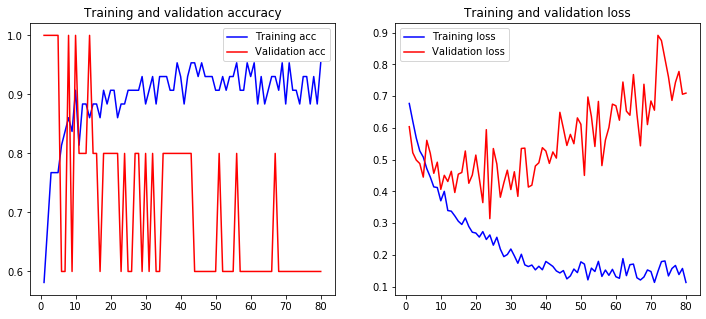

In [113]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [114]:
score = model.evaluate(test_X, test_Y, batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

21/21 [==============================] - 0s 1ms/step
Test accuracy: 0.7142857142857143


In [115]:
prediction = model.predict(tokenize.texts_to_matrix('return the ring'))
predicted_label = np.argmax(prediction[0])
print(predicted_label)

0


In [ ]:
# Optimieren: https://realpython.com/python-keras-text-classification/